# 0.导包、util

In [1]:
import tensorflow as tf
import numpy as np
import pdb, os, sys
import time
import argparse

import matplotlib.pyplot as plt  
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def cal_mean():
    data, label = read_cifar10('train')
    mean = np.mean(data, axis=0)
    return mean

In [3]:
class bcolors:
    END  = '\033[0m'  # white (normal)
    R  = '\033[31m' # red
    G  = '\033[32m' # green
    O  = '\033[33m' # orange
    B  = '\033[34m' # blue
    P  = '\033[35m' # purple
    BOLD = '\033[1m'

# 1.全局基础变量

In [4]:
def parse_args():
    parser = argparse.ArgumentParser(description='teacher-student model')
    # 方法设置
    parser.add_argument('--mxl', action='store_true', default=True, help='mxl method')
    parser.add_argument('--noisy', action='store_true', default=False, help='noisy teacher, hiton2017')
    parser.add_argument('--KD', action='store_true', default=False, help='knowledge distilling, hinton 2014')
    parser.add_argument('--NIPS', action='store_true', default=False, help='NIPS2014')

    # 公共设置
    parser.add_argument('--model', dest='model', default='savemodel', help="model_path to save the student model\n In testing, give trained student model.", type=str)
#     parser.add_argument('--task', dest='task', default='train', help='task for this file, train/test/val', type=str)
    parser.add_argument('--lr', dest='lr', default=0.0001, help='learning rate', type=float)
    parser.add_argument('--epoch', dest='epoch', default=100, help='total epoch', type=int)
    parser.add_argument('--batchsize', dest='batchsize', default=256, type=int)
    parser.add_argument('--dropout', dest='dropout', default=0.2, help="dropout ratio", type=float)
    
    # 知识蒸馏方法设置
    parser.add_argument('--tau', dest='tau', default=4, help='KD method. tau stands for temperature.', type=float)
    parser.add_argument('--lamda', dest='lamda', default=0.3, help='KD method. lamda between original loss and soft-target loss.', type=float)
    
    # noisy teacher设置
    parser.add_argument('--noisy_ratio', dest='Nratio', default=0.5, help="noisy ratio", type=float)
    parser.add_argument('--noisy_sigma', dest='Nsigma', default=0.01, help="noisy sigma", type=float)

    args = parser.parse_args([])
    return args, parser

In [5]:
global args,parser,x,y,keep_prob,sess

args, parser = parse_args()
batch_size = args.batchsize
dim = 32
n_classes = 10

# 2.读数据

In [6]:
# Reading cifar dataset
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo
#                            , encoding='bytes'
                          )
    return dict
def read_cifar10(flag):
    # Directory of cifar-10
    # 四维，[图片编号,长度,宽度,通道]
    path = '../1.data/Cifar10/py'
    if flag == 'train':
        batches = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
        data = np.uint8(np.zeros((50000,32,32,3)))
        label=np.int16(np.zeros((50000,1)))
    elif flag == 'test':
        batches = ['test_batch']
        data = np.float32(np.zeros((10000,32,32,3)))
        label= np.zeros((10000,1))

    N = 10000
    for i in range(len(batches)): # 一共5个batch
        b = batches[i]
        temp = unpickle(os.path.join(path,b))

        for j in range(N): # 每个batch10000个
            data[N*i+j][:,:,2] = np.reshape(temp[b'data'][j][2048:],(32,32)) # 通道1
            data[N*i+j][:,:,1] = np.reshape(temp[b'data'][j][1024:2048],(32,32)) # 通道2
            data[N*i+j][:,:,0] = np.reshape(temp[b'data'][j][:1024],(32,32)) # 通道3
            label[N*i+j] = temp[b'labels'][j]
    return data, label

# 3.模型定义
## 3.1修饰层

In [7]:
# function of CNN model reference: https://github.com/aymericdamien/TensorFlow-Examples/
# Create some wrappers for simplicity
def conv(x, W, b, strides=1, padding='SAME'):
    # Conv2D wrapper, with bias and relu activation
    #x = tf.pad(x, paddings, "CONSTANT")
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
    x = tf.nn.bias_add(x, b)
    return x

def maxpool2d(x, k, s, padding='SAME'):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, s, s, 1],
                          padding=padding)

def avgpool2d(x, k, s, padding='SAME'):
    # AvgPool2D wrapper
    return tf.nn.avg_pool(x, ksize=[1, k, k, 1], strides=[1, s, s, 1],
                          padding=padding)

## 3.2教师网络——network in network

In [8]:
# Create model
def nin(): # modify from model - network in network

    # pre-trained weight
    npyfile = np.load('../0.reference/1.model_distilling/teacher.npy'
#                       ,encoding = 'latin1'
                     )
    npyfile = npyfile.item()

    weights = {
        'conv1': tf.Variable(npyfile['conv1']['weights'], trainable=False, name = 'conv1_w'),
        'cccp1': tf.Variable(npyfile['cccp1']['weights'], trainable=False, name = 'cccp1_w'),
        'cccp2': tf.Variable(npyfile['cccp2']['weights'], trainable=False, name = 'cccp2_w'),
        
        'conv2': tf.Variable(npyfile['conv2']['weights'], trainable=False, name = 'conv2_w'),
        'cccp3': tf.Variable(npyfile['cccp3']['weights'], trainable=False, name = 'cccp3_w'),
        'cccp4': tf.Variable(npyfile['cccp4']['weights'], trainable=False, name = 'cccp4_w'),
        
        'conv3': tf.Variable(npyfile['conv3']['weights'], trainable=False, name = 'conv3_w'),
        'cccp5': tf.Variable(npyfile['cccp5']['weights'], trainable=False, name = 'cccp5_w'),
        
        'ip1': tf.Variable(npyfile['ip1']['weights'], trainable=False, name = 'ip1_w'),
        'ip2': tf.Variable(npyfile['ip2']['weights'], trainable=False, name = 'ip2_w')
    }

    biases = {
        'conv1': tf.Variable(npyfile['conv1']['biases'], trainable=False, name = 'conv1_b'),
        'cccp1': tf.Variable(npyfile['cccp1']['biases'], trainable=False, name = 'cccp1_b'),
        'cccp2': tf.Variable(npyfile['cccp2']['biases'], trainable=False, name = 'cccp2_b'),
        
        'conv2': tf.Variable(npyfile['conv2']['biases'], trainable=False, name = 'conv2_b'),
        'cccp3': tf.Variable(npyfile['cccp3']['biases'], trainable=False, name = 'cccp3_b'),
        'cccp4': tf.Variable(npyfile['cccp4']['biases'], trainable=False, name = 'cccp4_b'),
        
        'conv3': tf.Variable(npyfile['conv3']['biases'], trainable=False, name = 'conv3_b'),
        'cccp5': tf.Variable(npyfile['cccp5']['biases'], trainable=False, name = 'cccp5_b'),
        
        'ip1': tf.Variable(npyfile['ip1']['biases'], trainable=False, name = 'ip1_b'),
        'ip2': tf.Variable(npyfile['ip2']['biases'], trainable=False, name = 'ip2_b')
    }

    conv1 = conv(x, weights['conv1'], biases['conv1'])
    conv1_relu = tf.nn.relu(conv1)
    cccp1 = conv(conv1_relu, weights['cccp1'], biases['cccp1'])
    cccp1_relu = tf.nn.relu(cccp1)
    cccp2 = conv(cccp1_relu, weights['cccp2'], biases['cccp2'])
    cccp2_relu = tf.nn.relu(cccp2)
    pool1 = maxpool2d(cccp2_relu, k=3, s=2)
    drop3 = tf.nn.dropout(pool1, keep_prob)

    conv2 = conv(drop3, weights['conv2'], biases['conv2'])
    conv2_relu = tf.nn.relu(conv2)
    cccp3 = conv(conv2_relu, weights['cccp3'], biases['cccp3'])
    cccp3_relu = tf.nn.relu(cccp3)
    cccp4 = conv(cccp3_relu, weights['cccp4'], biases['cccp4'])
    cccp4_relu = tf.nn.relu(cccp4)
    pool2 = avgpool2d(cccp4_relu, k=3, s=2)
    drop6 = tf.nn.dropout(pool2, keep_prob)

    conv3 = conv(drop6, weights['conv3'], biases['conv3'])
    conv3_relu = tf.nn.relu(conv3)
    cccp5 = conv(conv3_relu, weights['cccp5'], biases['cccp5'])
    cccp5_relu = tf.nn.relu(cccp5)

    # inner product
    ip1 = tf.reshape(cccp5_relu, [-1, weights['ip1'].get_shape().as_list()[0]])
    ip1 = tf.add(tf.matmul(ip1, weights['ip1']), biases['ip1'])
    ip1_relu = tf.nn.relu(ip1)
    ip2 = tf.add(tf.matmul(ip1_relu, weights['ip2']), biases['ip2'])

    return ip2

## 3.3学生网络——lenet

In [9]:
def lenet(use_pretrained=False): # modify from lenet model

    if use_pretrained == False:
        # Random initialize
        weights = {
            'conv1': tf.get_variable('LN_conv1_w', [5,5,3,64],initializer=tf.contrib.layers.xavier_initializer_conv2d()),
            'conv2': tf.get_variable('LN_conv2_w', [5,5,64,128],initializer=tf.contrib.layers.xavier_initializer_conv2d()),
            'ip1': tf.get_variable('LN_ip1_w', [5*5*128, 1024] , initializer=tf.contrib.layers.xavier_initializer()),
            'ip2': tf.get_variable('LN_ip2_w', [1024,10], initializer=tf.contrib.layers.xavier_initializer())
        }

        biases = {
            'conv1': tf.Variable(tf.random_normal(shape=[64],stddev=0.5), name = 'LN_conv1_b'),
            'conv2': tf.Variable(tf.random_normal(shape=[128],stddev=0.5), name = 'LN_conv2_b'),
            'ip1': tf.Variable(tf.random_normal(shape=[1024],stddev=0.5), name = 'LN_ip1_b'),
            'ip2': tf.Variable(tf.random_normal(shape=[10],stddev=0.5), name = 'LN_ip2_b')
        }
    else:
        # initialized by pre-trained weight
        npyfile = np.load('../0.reference/1.model_distilling/student.npy',
#                           encoding = 'latin1'
                         )
        npyfile = npyfile.item()
        weights = {
            'conv1': tf.Variable(npyfile['conv1']['weights'], name = 'LN_conv1_w'),
            'conv2': tf.Variable(npyfile['conv2']['weights'], name = 'LN_conv2_w'),
            'ip1': tf.Variable(npyfile['ip1']['weights'], name = 'LN_ip1_w'),
            'ip2': tf.Variable(npyfile['ip2']['weights'], name = 'LN_ip2_w'),
        }

        biases = {
            'conv1': tf.Variable(npyfile['conv1']['biases'], name = 'LN_conv1_b'),
            'conv2': tf.Variable(npyfile['conv2']['biases'], name = 'LN_conv2_b'),
            'ip1': tf.Variable(npyfile['ip1']['biases'], name = 'LN_ip1_b'),
            'ip2': tf.Variable(npyfile['ip2']['biases'], name = 'LN_ip2_b'),
        }

    conv1 = conv(x, weights['conv1'], biases['conv1'],padding='VALID')
    pool1 = maxpool2d(conv1, k=2, s=2)
    conv2 = conv(pool1, weights['conv2'], biases['conv2'], padding='VALID')
    pool2 = maxpool2d(conv2, k=2, s=2,padding='VALID')

    ip1 = tf.reshape(pool2, [-1, weights['ip1'].get_shape().as_list()[0]])
    ip1 = tf.add(tf.matmul(ip1, weights['ip1']), biases['ip1'])
    ip1_relu = tf.nn.relu(ip1)
    ip2 = tf.add(tf.matmul(ip1_relu, weights['ip2']), biases['ip2'])
    return ip2

# 4.训练
## 4.1模型

In [10]:
print (bcolors.G+"Reading args....")

# 处理参数
print (args)
print (bcolors.END)
if args.noisy == True and args.KD == True:
    print (bcolors.BOLD+bcolors.R+"Invalid args!\n"+bcolors.END+bcolors.R+"only one method can be selected, noisy or KD(knowledge distilling)"+bcolors.END)
    exit(1)
learning_rate=args.lr
model_path=args.model
total_epoch = args.epoch
batch_size_one = batch_size

# 读取数据
# 四维，[batchsize图片编号,长度,宽度,通道]
x = tf.placeholder(tf.float32, [batch_size, dim, dim, 3])
y = tf.placeholder(tf.int32, [batch_size])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)


data, label=read_cifar10('train')
index=np.array(range(len(data)))    # index randomly ordered
mean = cal_mean()

data_valid, label_valid = read_cifar10('test')

# 定义训练模型（无softmax）
teacher=nin()
student=lenet()

# 验证加softmax
pred = tf.nn.softmax(student)

Reading args....
Namespace(KD=False, NIPS=False, Nratio=0.5, Nsigma=0.01, batchsize=256, dropout=0.2, epoch=100, lamda=0.3, lr=0.0001, model='savemodel', mxl=True, noisy=False, tau=4)



# 4.2目标函数

In [11]:
# 定义loss函数
if args.mxl == True:
    print (bcolors.G+"prepare for training, Xiaolong18 mode"+bcolors.END)
    # 选出一些样本加噪声
    noisy_mask = tf.nn.dropout(tf.constant(np.float32(np.ones((batch_size,1))) * args.Nratio) ,keep_prob=args.Nratio) #(batchsize,1)
    gaussian = tf.random_normal(shape=[batch_size,1], mean=0.0, stddev=args.Nsigma)
    noisy = tf.multiply(noisy_mask, gaussian)
    noisy_add = tf.add(tf.constant(np.float32(np.ones((batch_size,1)))), noisy)
    teacher = tf.multiply(teacher, tf.tile(noisy_add,tf.constant([1,10])))
    
    one_hot = tf.one_hot(y, n_classes,1.0,0.0)
    teacher_tau = tf.scalar_mul(1.0/args.tau, teacher)
    student_tau = tf.scalar_mul(1.0/args.tau, student)

    objective1 = tf.nn.softmax_cross_entropy_with_logits(logits = tf.scalar_mul(args.tau, student_tau), labels = one_hot) # ？
    
    objective2 = tf.nn.softmax_cross_entropy_with_logits(logits = student_tau,labels = tf.nn.softmax(teacher_tau))
    objective2 = tf.scalar_mul(2 * args.tau * args.tau, objective2)
    
    tf_loss = (
        args.lamda*tf.reduce_sum(objective1)
        + (1-args.lamda)*tf.reduce_sum(objective2)
    )/batch_size

elif args.noisy == True:
    print (bcolors.G+"prepare for training, Hinton17 mode"+bcolors.END)

    # 选出一些样本加噪声
    noisy_mask = tf.nn.dropout(tf.constant(np.float32(np.ones((batch_size,1))) * args.Nratio) ,keep_prob=args.Nratio) #(batchsize,1)
    gaussian = tf.random_normal(shape=[batch_size,1], mean=0.0, stddev=args.Nsigma)
    noisy = tf.multiply(noisy_mask, gaussian)
    noisy_add = tf.add(tf.constant(np.float32(np.ones((batch_size,1)))), noisy)
    
    teacher = tf.multiply(teacher, tf.tile(noisy_add,tf.constant([1,10])))
#     teacher = tf.add(teacher, tf.tile(noisy,tf.constant([1,10])))
    tf_loss = tf.nn.l2_loss(teacher - student)/batch_size

elif args.KD == True:   # correct Hinton method at 2017.1.3
    print (bcolors.G+"prepare for training, Hiton14 mode"+bcolors.END)
    
    one_hot = tf.one_hot(y, n_classes,1.0,0.0)
    teacher_tau = tf.scalar_mul(1.0/args.tau, teacher)
    student_tau = tf.scalar_mul(1.0/args.tau, student)

    objective1 = tf.nn.softmax_cross_entropy_with_logits(logits = tf.scalar_mul(args.tau, student_tau), labels = one_hot) # ？
#     objective2 = tf.scalar_mul(2 * args.tau * args.tau, tf.nn.softmax_cross_entropy_with_logits(logits = student_tau, labels = tf.nn.softmax(teacher_tau)))
    objective2 = tf.scalar_mul(2 * args.tau * args.tau, tf.nn.softmax_cross_entropy_with_logits(logits = student_tau, labels = tf.nn.softmax(teacher_tau)))
    #     objective2 = tf.nn.l2_loss(student_tau-teacher_tau)
    
    tf_loss = (args.lamda*tf.reduce_sum(objective1) + (1-args.lamda)*tf.reduce_sum(objective2))/batch_size

elif args.NIPS == True:
    print (bcolors.G+"prepare for training, NIPS2014 mode"+bcolors.END)
    tf_loss = tf.nn.l2_loss(teacher - student)/batch_size # 相减

prepare for training, Xiaolong18 mode
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



# 4.3优化算法

In [12]:
# 定义优化算法
optimizer1 = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(tf_loss)
optimizer2 = tf.train.AdamOptimizer(learning_rate=learning_rate/10).minimize(tf_loss)

## 4.4运行

number of iterations (per epoch) =195
epoch 0 - avg. 9.780607 seconds in each epoch, cost = 8386.193037 , avg-cost-per-logits = 4.300612 ,  acc = 0.537760, correct = 5369, total = 9984
epoch 1 - avg. 8.854076 seconds in each epoch, cost = 5364.206459 , avg-cost-per-logits = 2.750875 ,  acc = 0.582532, correct = 5816, total = 9984
epoch 2 - avg. 8.560766 seconds in each epoch, cost = 4418.951910 , avg-cost-per-logits = 2.266129 ,  acc = 0.619191, correct = 6182, total = 9984
epoch 3 - avg. 8.412112 seconds in each epoch, cost = 3724.991888 , avg-cost-per-logits = 1.910252 ,  acc = 0.622296, correct = 6213, total = 9984
epoch 4 - avg. 8.339254 seconds in each epoch, cost = 3179.754663 , avg-cost-per-logits = 1.630643 ,  acc = 0.649239, correct = 6482, total = 9984
epoch 5 - avg. 8.301697 seconds in each epoch, cost = 2688.332740 , avg-cost-per-logits = 1.378632 ,  acc = 0.650040, correct = 6490, total = 9984
epoch 6 - avg. 8.268521 seconds in each epoch, cost = 2290.130687 , avg-cost-per

epoch 54 - avg. 8.473672 seconds in each epoch, cost = 757.936727 , avg-cost-per-logits = 0.388686 ,  acc = 0.683193, correct = 6821, total = 9984
epoch 55 - avg. 8.472064 seconds in each epoch, cost = 752.614079 , avg-cost-per-logits = 0.385956 ,  acc = 0.683894, correct = 6828, total = 9984
epoch 56 - avg. 8.473614 seconds in each epoch, cost = 745.228739 , avg-cost-per-logits = 0.382169 ,  acc = 0.684996, correct = 6839, total = 9984
epoch 57 - avg. 8.468327 seconds in each epoch, cost = 738.087798 , avg-cost-per-logits = 0.378507 ,  acc = 0.687200, correct = 6861, total = 9984
epoch 58 - avg. 8.463746 seconds in each epoch, cost = 741.891592 , avg-cost-per-logits = 0.380457 ,  acc = 0.685697, correct = 6846, total = 9984
epoch 59 - avg. 8.462091 seconds in each epoch, cost = 743.345144 , avg-cost-per-logits = 0.381203 ,  acc = 0.685797, correct = 6847, total = 9984
('Epoch ', 60, ' is done. Saving the model ...')
epoch 60 - avg. 8.470801 seconds in each epoch, cost = 743.715908 , a

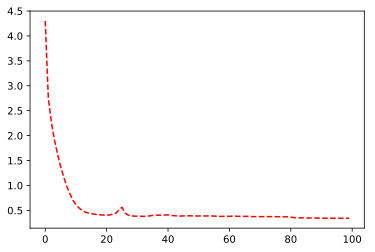

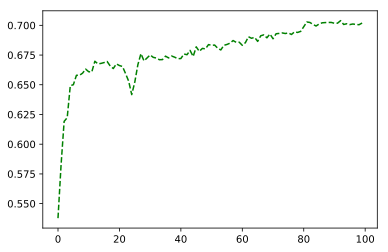

In [13]:
# 定义、初始化设置选项
begin = time.time()
iterations = int(len(data)/batch_size)
decay_step = int(total_epoch*0.8)
cnt=0
dropout_rate=args.dropout
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1.0)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
tf.global_variables_initializer().run()
saver = tf.train.Saver(max_to_keep=100)

# 迭代
costs = []
costs_valid = []
print (bcolors.G+"number of iterations (per epoch) ="+str(len(data)/batch_size)+bcolors.END)
for i in range(total_epoch):
    # 训练
    np.random.shuffle(index)
    cost_sum=0
    for j in range(iterations):
        batch_x = np.float32(data[index[j*batch_size:(j+1)*batch_size]]) - mean
        batch_y = np.squeeze(np.float32(label[index[j*batch_size:(j+1)*batch_size]]))
        if cnt/decay_step == 0:
            lr=learning_rate
            _, cost = sess.run([optimizer1, tf_loss],
                feed_dict={x : batch_x, y : batch_y, keep_prob : 1 - dropout_rate})
        elif cnt/decay_step == 1:
            lr=learning_rate/10
            _, cost = sess.run([optimizer2, tf_loss],
                feed_dict={x : batch_x, y : batch_y, keep_prob : 1 - dropout_rate})
        cost_sum += cost

    cnt +=1
    avg_time = time.time()-begin
    costs += [cost_sum/iterations/n_classes]
    
    # 验证
    total=0
    correct=0
    for j in range(len(data_valid)/batch_size_one):
        batch_x_valid = data_valid[j*batch_size_one:(j+1)*batch_size_one] - mean
        prob = sess.run([pred],
                feed_dict={x : batch_x_valid, y : np.ones((batch_size_one)), keep_prob : 1.0})
        for k in range(batch_size_one):
            if np.argmax(prob[0][k]) == label_valid[j * batch_size_one + k]:
                correct += 1
            total+=1
    costs_valid += [correct * 1.0 / total]
    
    print ("epoch %d - avg. %f seconds in each epoch, cost = %f , avg-cost-per-logits = %f ,  acc = %f, correct = %d, total = %d"
           %(i, avg_time/cnt, cost_sum, cost_sum/iterations/n_classes, correct * 1.0 / total, correct, total))

    # 保存模型
    if np.mod(i+1, 10) == 0:
        print ("Epoch ", i+1, " is done. Saving the model ...")
        with tf.device('/cpu:0'):
            if not os.path.exists(model_path):
                os.makedirs(model_path)
            saver.save(sess, os.path.join(model_path, 'model'), global_step=i)
    sys.stdout.flush()

# 绘图
print('The best epoch is %d with acc %f'%(np.argmax(costs_valid),max(costs_valid)))
plt.plot(range(total_epoch), costs, linestyle='--', color='red')
plt.show()  
plt.plot(range(total_epoch), costs_valid, linestyle='--', color='green')
plt.show()

# 5.验证——Teacher

In [14]:
# batch_size_one=1
# print (bcolors.G+"Reading args....")
# print (args)
# print (bcolors.END)
# if args.noisy == True and args.KD == True:
#     print (bcolors.BOLD+bcolors.R+"Invalid args!\n"+bcolors.END+bcolors.R+"only one method can be selected, noisy or KD(knowledge distilling)"+bcolors.END)
#     exit(1)

# # 定义占位符
# # 四维，[batchsize图片编号,长度,宽度,通道]
# x = tf.placeholder(tf.float32, [batch_size_one, dim, dim, 3])
# y = tf.placeholder(tf.int32, [batch_size_one])
# keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

# print (bcolors.G+"Task : val\nvalidate the pre-trained nin model, should be same as caffe result"+bcolors.END)
# pool3=nin()
# sess = tf.InteractiveSession()
# init=tf.initialize_all_variables()
# sess.run(init)
# mean = cal_mean()
# data, label=read_cifar10('test')
# total=0
# correct=0
# begin = time.time()
# for j in range(len(data)/batch_size_one):
#     batch_x = data[j*batch_size_one:(j+1)*batch_size_one] - mean
#     prob = sess.run([pool3],
#             feed_dict={x : batch_x, y : np.ones((batch_size_one)), keep_prob : 1.0})
#     if np.argmax(prob[0]) == label[j]:
#         correct += 1
#     total+=1
# end = time.time()
# print ("acc = %f . %d/%d.  Computing time = %f seconds"%(float(correct)/total, correct, total, end-begin))

# 6.验证——Student

In [15]:
# batch_size_one=1
# print (bcolors.G+"Reading args....")
# print (args)
# print (bcolors.END)
# if args.noisy == True and args.KD == True:
#     print (bcolors.BOLD+bcolors.R+"Invalid args!\n"+bcolors.END+bcolors.R+"only one method can be selected, noisy or KD(knowledge distilling)"+bcolors.END)
#     exit(1)


# # 定义占位符
# # 四维，[batchsize图片编号,长度,宽度,通道]
# x = tf.placeholder(tf.float32, [batch_size_one, dim, dim, 3])
# y = tf.placeholder(tf.int32, [batch_size_one])
# keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

# print (bcolors.G+"Task : test\n"+bcolors.END)
# student = lenet()
# pred = tf.nn.softmax(student)
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
# sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
# init=tf.global_variables_initializer()
# sess.run(init)
# with tf.device('/cpu:0'):
#     saver = tf.train.Saver()
# #         saver.restore(sess, args.model)
#     ckpt = tf.train.get_checkpoint_state(args.model)  
#     if ckpt and ckpt.model_checkpoint_path:  
#         saver.restore(sess, ckpt.model_checkpoint_path)  

# mean = cal_mean()
# data, label=read_cifar10('test')
# total=0
# correct=0
# begin = time.time()
# for j in range(len(data)/batch_size_one):
#     batch_x = data[j*batch_size_one:(j+1)*batch_size_one] - mean
#     prob = sess.run([pred],
#             feed_dict={x : batch_x, y : np.ones((batch_size_one)), keep_prob : 1.0})
#     if np.argmax(prob[0]) == label[j]:
#         correct += 1
#     total+=1
#     #print ("acc = %f . %d/%d"%(float(correct)/total, correct, total))
# end = time.time()
# print ("acc = %f . %d/%d.  Computing time = %f seconds"%(float(correct)/total, correct, total, end-begin))